In [1]:
import math
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
import math 
import scipy.constants as const
import time

In [3]:
events = pd.read_csv('Sample_Game_1_RawEventsData.csv') # read data
home = pd.read_csv('Game1_Home.csv') # read data
away = pd.read_csv('Game1_Away.csv') # read data

p_length = 110
p_width = 65

In [4]:
home_players = list({player[0:len(player)-2] for player in list(home)[3:30]})
away_players = list({player[0:len(player)-2] for player in list(away)[3:30]})

In [5]:
events[events.Type=='PASS'].Subtype.unique()

array([nan, 'HEAD', 'CROSS', 'GOAL KICK', 'DEEP BALL',
       'THROUGH BALL-DEEP BALL', 'HEAD-CLEARANCE', 'CLEARANCE'],
      dtype=object)

In [6]:
subtypes = ['CROSS','GOAL KICK','DEEP BALL','THROUGH BALL-DEEP BALL']

In [7]:
passes = events[(events.Type=='PASS')&((events.Subtype.isnull())|(events.Subtype.isin(subtypes)))].copy()
passes['time'] = passes['End Time [s]'] - passes['Start Time [s]']
passes['distance'] =((110*(passes['Start X']-passes['End X']))**2+(65*(passes['Start Y']-passes['End Y']))**2)**0.5
passes['speed'] = passes['distance']/passes['time']

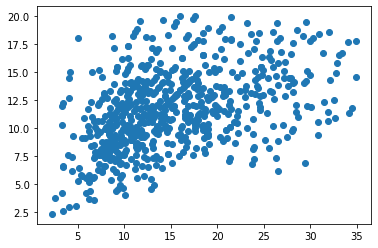

In [8]:
val = passes[(passes.distance<35)&(passes.speed<20)]
plt.scatter(val['distance'],val['speed'])

In [9]:
pass_speed_max = 20
reception_speed_max = pass_speed_max
min_angle = 5
max_angle = 50

player_time_reaction = 0.7 #laurie
player_acceleration = 5 #laurie reference
player_speed_max = 5 #laurice

ball_mass = 0.43 #FIFA min and max weight: 0.41 and 0.45 kg
ball_area = math.pi*(0.69/2)**2 #Fifa min and max circumference: 0.68 and 0.70 m
ball_drag = 0.25

g = const.g 
air_density = 1.2

In [10]:
def ball_trayectory(angle,speed):    
    
    dt = 0.001
    theta = (angle/180)*math.pi
    x,y,vx,vy = [0],[0],[speed*math.cos(theta)],[speed*math.sin(theta)]
    
    i=1
    while vx[i-1]>=1:               
        
        x.append(x[i-1]+vx[i-1]*dt)
        y.append(max(y[i-1]+vy[i-1]*dt,0))
        
        vy.append(vy[i-1] -g*dt -(air_density*ball_drag*ball_area*vy[i-1])/(2*ball_mass)*dt) 
        
        if y[i] > 0.1:
            vx.append(vx[i-1] -(air_density*ball_drag*ball_area*vx[i-1])/(2*ball_mass)*dt)                    
        else:
            #y[i] = 0
            vx.append(vx[i-1] -6*(air_density*ball_drag*ball_area*vx[i-1])/(2*ball_mass)*dt) ## estimate
            
        if y[i]==0:
            vy[i] = abs(vy[i])*0.7
            if y[i-1]>0:
                vx[i] = abs(vx[i])*0.7
            if vy[i]<1:
                vy[i] = 0
            
  
        i += 1    
        
    return np.array(x),np.array(y)#,vx,vy

In [11]:
passes_all = pd.DataFrame(columns=['angle','speed','distance','time'])
trayectory_all = pd.DataFrame(columns=['angle','speed','xt','yt'])
speeds = np.linspace(1,pass_speed_max+1,2*(pass_speed_max+1)-1)

for angle in range(min_angle,max_angle+1):
    for speed in speeds:
        
        x,y = ball_trayectory(angle,speed)     
        
        aux1 = pd.DataFrame([angle,speed,x,y]).transpose()
        aux1.columns = ['angle','speed','xt','yt']
        trayectory_all = trayectory_all.append(aux1)
        
        index = np.where([y==0])[1][1:]       
        
        if (angle <= min_angle)&(len(index)>0): 
            index = np.array([min(index)+x*100 for x in range(0,1+int((len(index)-min(index))/100))])          
        
        if len(index) > 0:            
            aux2 = pd.DataFrame([[angle]*len(index),[speed]*len(index),np.round(x[index],1),np.round(index*0.001,1)]).transpose()
            aux2.columns = ['angle','speed','distance','time']
            passes_all = passes_all.append(aux2)
            
passes_all = passes_all.drop_duplicates()

(0, 35, 0, 5)

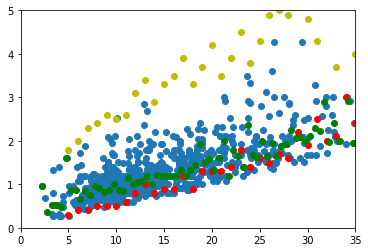

In [12]:
passes_best = pd.DataFrame(columns=['angle','speed','distance','time'])
passes_worst = pd.DataFrame(columns=['angle','speed','distance','time'])
d = np.array([x for x in range(5,36)])
e = 0.1

for x in d:
    aux = passes_all[(passes_all.distance>x-e)&(passes_all.distance<x+e)].sort_values('time').head(1)
    aux2 = passes_all[(passes_all.distance>x-e)&(passes_all.distance<x+e)].sort_values('time', ascending=False).head(1)
    passes_best = passes_best.append(aux)    
    passes_worst = passes_worst.append(aux2)    
    
xx = []
yy = []
bins = np.linspace(1,35,69)
for i in range(0,len(bins)-1):
    
    aux =  passes[(passes.distance>=bins[i])&(passes.distance<bins[i+1])]
    den = len(aux)
    if den > 0:
        xx.append((bins[i]+bins[i+1])/2)
        yy.append([np.median(aux.time)])
        
plt.scatter(val['distance'],val['time'])
plt.scatter(passes_best.distance,passes_best.time,c='r')
plt.scatter(passes_worst.distance,passes_worst.time,c='y')
plt.scatter(xx,yy,c='g')
plt.axis((0,35,0,5))

In [13]:
def dist_pass(start,end,player):
    
    x_initial,y_initial = start[0],start[1]
    x_final,y_final = end[0],end[1]
    x0,y0 = player[0]*p_length,player[1]*p_width
    
    a = (y_final-y_initial)*p_width
    b = (x_initial-x_final)*p_length
    c = -a*x_initial*p_length - b*y_initial*p_width
    
    return float(abs(a*x0+b*y0+c)/(a**2+b**2)**0.5)

In [14]:
def dist(pos1,pos2):
    x0,y0 = pos1[0]*p_length, pos1[1]*p_width
    x1,y1 = pos2[0]*p_length, pos2[1]*p_width
    return np.linalg.norm(np.asarray([x0,y0])-np.asarray([x1,y1]))

In [15]:
e = 0.1
error_time = pd.DataFrame(columns=['distance','actual','model'])

for i in range(len(passes)):
    
    model_time = None
    
    pass1 = passes.iloc[i]
    actual_time = pass1.time
    actual_distance = pass1.distance
    start_pos = pass1[['Start X','End X']]
    end_pos = pass1[['Start Y','End Y']]    
    status = away[away.Frame==pass1['Start Frame']]
    
    intercepetions =  pd.DataFrame(columns=['distance','time'])

    for player in away_players:
        if status[player+'_x'].isnull().iloc[0]==False:

            player_pos = status.iloc[0][[player+'_x',player+'_y']]
            d1 = dist_pass(start_pos,end_pos,player_pos)
            d2 = dist(start_pos,player_pos)
            d3 = (d2**2-d1**2)**0.5
            if d3 < pass1.distance-2:            
                intercepetions.loc[len(intercepetions)] = [d3,d1/7]

    intercepetions = intercepetions.sort_values('distance',ascending=False)
    intercepetions.reset_index(drop=True)

    possible = passes_all[(passes_all.distance>pass1.distance-e)&(passes_all.distance<pass1.distance+e)].sort_values('time').copy()
    possible = possible.reset_index(drop=True)
    
    for i in range(int(len(possible)/15),len(possible)):
        a,s,t = possible.iloc[i][['angle','speed','time']]
        aux = trayectory_all[(trayectory_all.angle==a)&(trayectory_all.speed==s)][['xt','yt']]
        aux = pd.DataFrame([aux.xt[0],aux.yt[0]]).transpose()
        aux.columns = ['xt','yt']
        for i in range(len(intercepetions)):
            distance,time = intercepetions.iloc[i]
            frame = int(time*1000)
            if frame < len(aux):
                xt,yt = aux.iloc[frame]
                if (xt<distance)&(yt<2.5):
                    break
        model_time = t
        break    
        
    error_time.loc[len(error_time)] = [actual_distance,actual_time,model_time]

In [16]:
len(error_time[error_time.model.isnull()])/len(error_time)

0.00902061855670103

In [17]:
error_time['error_perc'] = (error_time.actual-error_time.model)/error_time.actual

In [18]:
error_final = error_time[(~error_time.model.isnull())&(error_time.actual>0.1)]

In [19]:
np.mean(error_final.error_perc)

-0.04733246029041446

In [20]:
np.median(error_final.error_perc)

3.7932620008024745e-14

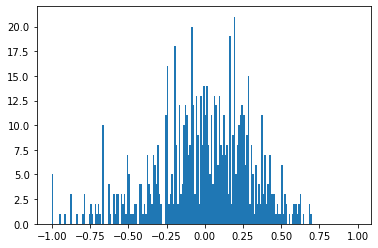

In [21]:
plt.hist(error_final.error_perc,bins=[i/100 for i in range(-100,100)])
plt.show()

In [22]:
len(error_final[(error_final.error_perc<0.3)&(error_final.error_perc>-0.3)])/len(error_final)

0.6718954248366014

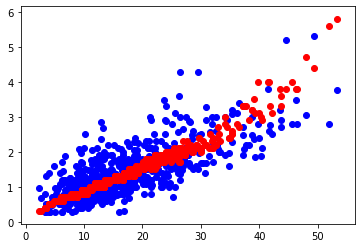

In [23]:
plt.scatter(error_final['distance'],error_final['actual'],c='b')
plt.scatter(error_final['distance'],error_final['model'],c='r')